[*********************100%***********************]  11 of 11 completed


Daily returns CSV saved to: /Users/karthikprasannakumar/Downloads/daily_returns.csv
     pcost       dcost       gap    pres   dres
 0:  1.0197e-04 -1.0004e+00  1e+00  2e-16  3e+00
 1:  1.0196e-04 -9.9898e-03  1e-02  7e-17  4e-02
 2:  1.0073e-04 -8.5259e-05  2e-04  8e-17  6e-04
 3:  7.6616e-05  3.5559e-05  4e-05  7e-17  1e-04
 4:  6.1025e-05  5.3564e-05  7e-06  3e-16  7e-20
 5:  5.8199e-05  5.7652e-05  5e-07  1e-16  8e-20
 6:  5.7865e-05  5.7845e-05  2e-08  1e-16  9e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0197e-04 -1.0002e+00  1e+00  7e-17  3e+00
 1:  1.0196e-04 -9.9887e-03  1e-02  7e-17  4e-02
 2:  1.0073e-04 -8.5228e-05  2e-04  6e-17  6e-04
 3:  7.6634e-05  3.5787e-05  4e-05  1e-16  1e-04
 4:  6.1135e-05  5.3871e-05  7e-06  9e-17  7e-20
 5:  6.0752e-05  5.8063e-05  3e-06  3e-17  1e-19
 6:  5.9934e-05  5.9724e-05  2e-07  9e-17  2e-19
 7:  5.9888e-05  5.9867e-05  2e-08  2e-16  3e-18
Optimal solution found.
     pcost       dcost       gap    p

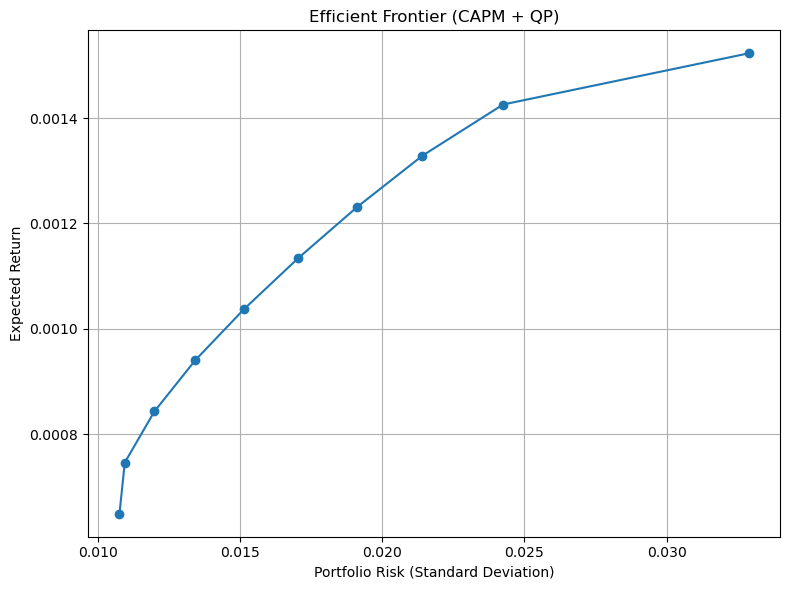

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import os

#Download historical price data

tickers = ['TSLA', 'F', 'GM','AAPL', 'QCOM', 'SWKS','MSFT', 'GOOGL', 'NVDA', 'AMD'] 
market_ticker = '^GSPC'
data = yf.download(tickers + [market_ticker], start='2023-04-01', end='2025-04-01', auto_adjust=False) # for last 2 finacial year
adj_close = data['Adj Close']

#Step 2: Calculate daily returns

returns = adj_close.pct_change().dropna()

#Save daily returns CSV on Mac Desktop

desktop_path = "/Users/karthikprasannakumar/Downloads/daily_returns.csv"  
returns.to_csv(desktop_path)
print(f"Daily returns CSV saved to: {desktop_path}")

#Separate stock and market returns

stock_returns = returns[tickers]
market_returns = returns[market_ticker]

#CAPM Regression

rf_annual = 0.02
rf_daily = (1 + rf_annual) ** (1 / 252) - 1  # daily risk-free rate

expected_returns = []
idiosyncratic_vars = []
betas = []
results = {}

for ticker in tickers:
    Ri = stock_returns[ticker]
    Rm = market_returns
    Yi = Ri - rf_daily
    X = Rm - rf_daily
    X = sm.add_constant(X)

    model = sm.OLS(Yi, X).fit()
    alpha, beta = model.params
    residuals = model.resid
    idio_var = residuals.var()

    E_Rm = Rm.mean()
    mu_i = rf_daily + beta * (E_Rm - rf_daily)

    results[ticker] = model
    expected_returns.append(mu_i)
    idiosyncratic_vars.append(idio_var)
    betas.append(beta)

#Covariance matrix construction
betas = np.array(betas)
sigma_m = market_returns.var()
Sigma = np.outer(betas, betas) * sigma_m  # systematic risk
np.fill_diagonal(Sigma, np.diag(Sigma) + idiosyncratic_vars)  # add idiosyncratic risk

#Quadratic Programming solver
def solve_qp(Sigma, mu, mu_p):
    n = len(mu)
    P = matrix(Sigma)
    q = matrix(np.zeros(n))

    G = matrix(np.vstack([-np.eye(n), -mu]))
    h = matrix(np.hstack([np.zeros(n), -mu_p]))

    A = matrix(1.0, (1, n))
    b = matrix(1.0)

    sol = solvers.qp(P, q, G, h, A, b)
    return np.array(sol['x']).flatten()

#Efficient frontier computation
mu = np.array(expected_returns)
returns_range = np.linspace(mu.min(), mu.max(), 10)
risks = []
weights_list = []

for mu_p in returns_range:
    w = solve_qp(Sigma, mu, mu_p)
    portfolio_variance = w @ Sigma @ w
    risks.append(np.sqrt(portfolio_variance))
    weights_list.append(w)

#Plot efficient frontier
plt.figure(figsize=(8,6))
plt.plot(risks, returns_range, marker='o')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (CAPM + QP)')
plt.grid(True)
plt.tight_layout()
plot_path = "/Users/karthikprasannakumar/Downloads/efficient_frontier.png"
plt.savefig(plot_path, dpi=300)  
print(f"Plot saved to: {plot_path}")

plt.show()
